In [1]:
import logging
logging.basicConfig(level=logging.INFO)
from itertools import product

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from fvcore.nn import FlopCountAnalysis
import numpy as np

import optuna

from vopy.algorithms import PaVeBaGPOnline
from vopy.maximization_problem import FixedPointsProblem
from vopy.order import ConeTheta2DOrder

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DIR = ".."
BATCHSIZE = 128
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10
INPUT_SIZE = 28 * 28


def generate_model(n_layers, n_units):
    layers = []

    in_features = INPUT_SIZE
    for i in range(n_layers):
        out_features = n_units

        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.25))

        in_features = out_features

    layers.append(nn.Linear(in_features, 10))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)


def train_model(model, optimizer, train_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.view(-1, INPUT_SIZE).to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        F.nll_loss(model(data), target).backward()
        optimizer.step()


def eval_model(model, valid_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.view(-1, INPUT_SIZE).to(DEVICE), target.to(DEVICE)
            pred = model(data).argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / N_VALID_EXAMPLES

    flops = FlopCountAnalysis(model, inputs=(torch.randn(1, INPUT_SIZE).to(DEVICE),)).total()
    return flops, accuracy

In [3]:
def max_objective(lr, n_layers, n_units):
    train_dataset = torchvision.datasets.FashionMNIST(
        DIR, train=True, download=True, transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(train_dataset, list(range(N_TRAIN_EXAMPLES))),
        batch_size=BATCHSIZE,
        shuffle=True,
    )

    val_dataset = torchvision.datasets.FashionMNIST(
        DIR, train=False, transform=torchvision.transforms.ToTensor()
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(val_dataset, list(range(N_VALID_EXAMPLES))),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    model = generate_model(n_layers, n_units).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr)

    for epoch in range(5):
        train_model(model, optimizer, train_loader)
    flops, accuracy = eval_model(model, val_loader)
    return -flops, accuracy

In [4]:
def optuna_objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_units = trial.suggest_int("n_units", 16, 64)
    lr = trial.suggest_int("lr", 1, 5)
    lr = 10**(-lr)

    return max_objective(lr, n_layers, n_units)

In [ ]:
# Run Optuna
study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(optuna_objective, n_trials=10, timeout=120)

print("Number of finished trials: ", len(study.trials))

In [5]:
def vopy_objective(x):
    return np.array(max_objective(x[0], x[1], x[2]))

lr_range = range(1, 6)
n_layers_range = range(1, 4)
n_units_range = range(16, 25)
in_pts = list(product(lr_range, n_layers_range, n_units_range))

vopy_problem = FixedPointsProblem(in_points=in_pts, out_dim=2, objective=vopy_objective)

epsilon = 0.01
delta = 0.05
order = ConeTheta2DOrder(90)
conf_contraction = 16
paveba = PaVeBaGPOnline(
    epsilon, delta, vopy_problem, order, conf_contraction=conf_contraction, initial_sample_cnt=10
)

In [6]:
# Run PaVeBa Online
while True:
    is_done = paveba.run_one_step()

    if is_done:
        break

pred_pareto_indices = sorted(list(paveba.P))

INFO:root:Round 1:Evaluating
INFO:root:Training started.
INFO:root:Training done.
INFO:root:Round 1:Modeling
/Users/teta/mamba/envs/vopy/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
INFO:root:Round 1:Discarding
INFO:root:Round 1:Pareto update
INFO:root:Round 1:Useful update
INFO:root:Round 1:There are 0 designs left in set S and 135 designs in set P.
INFO:root:Round 1:Sample count 1


In [13]:
p_mean, p_var = paveba.model.predict(np.array(in_pts))
print(np.min(p_mean, axis=0))
print(np.min(p_mean, axis=0))

[-9.74472962e+002  3.49173471e-133]
[-9.74472962e+002  3.49173471e-133]


/Users/teta/mamba/envs/vopy/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


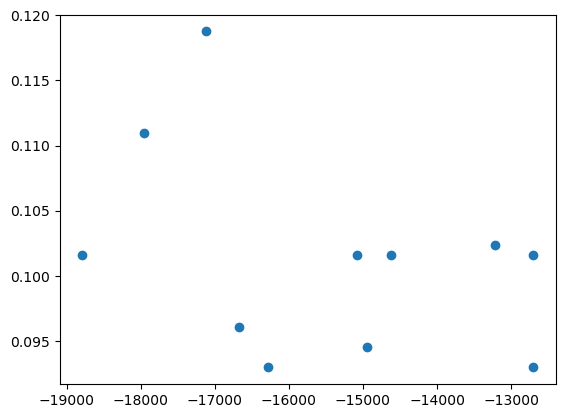

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(paveba.model.train_targets[:, 0], paveba.model.train_targets[:, 1])

plt.show()